## Inverse Cooking: Recipe Generation from Food Images

In [60]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

In [61]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # use GPU 0 and 1


Set ```data_dir``` to the path including vocabularies and model checkpoint

In [62]:
data_dir = '../data'

In [63]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [64]:
# class Vocabulary(object):
#     """Simple vocabulary wrapper."""
#     def __init__(self):
#         self.word2idx = {}
#         self.idx2word = {}
#         self.idx = 0

#     def add_word(self, word, idx=None):
#         if idx is None:
#             if not word in self.word2idx:
#                 self.word2idx[word] = self.idx
#                 self.idx2word[self.idx] = word
#                 self.idx += 1
#             return self.idx
#         else:
#             if not word in self.word2idx:
#                 self.word2idx[word] = idx
#                 if idx in self.idx2word.keys():
#                     self.idx2word[idx].append(word)
#                 else:
#                     self.idx2word[idx] = [word]

#                 return idx

#     def __call__(self, word):
#         if not word in self.word2idx:
#             return self.word2idx['<pad>']
#         return self.word2idx[word]

#     def __len__(self):
#         return len(self.idx2word)

In [65]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
# ingrs_vocab = pickle.load(open("/data/prateek/github/see-food/garbage/recipe1m_vocab_ingrs.pkl", 'rb'))
# ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
# vocab = pickle.load(open('/data/prateek/github/see-food/garbage/recipe1m_vocab_toks.pkl', 'rb')).idx2word
# pickle.dump(ingrs_vocab, open('../garbage/ingr_vocab.pkl', 'wb'))
# pickle.dump(vocab, open('../garbage/instr_vocab.pkl', 'wb'))

# ingrs_vocab = pickle.load(open('/data/prateek/github/see-food/paper_weights/ingr_vocab.pkl', 'rb'))
# vocab = pickle.load(open('/data/prateek/github/see-food/paper_weights/instr_vocab.pkl', 'rb'))

ingrs_vocab = pickle.load(open('/data/prateek/github/see-food/garbage/ingr_vocab.pkl', 'rb'))
vocab = pickle.load(open('/data/prateek/github/see-food/garbage/instr_vocab.pkl', 'rb'))


ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [66]:
print(instrs_vocab_size, ingr_vocab_size)

1631 208


In [67]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = '/data/prateek/github/see-food/checkpoints/inversecooking/end2end_vit/checkpoints/modelbest.ckpt'
model.load_state_dict(torch.load(model_path, map_location=map_loc))

model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


using vision: True


Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded model
Elapsed time: 2.9855124950408936


In [68]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [69]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [70]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = '../TEST_DATASET/images'

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

# demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
#             'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs
len(demo_files)

517

In [71]:
PRED_FOLDER = "../TEST_DATASET/PRED-baseline/"

instruction_folder = PRED_FOLDER + "/instructions"
title_folder = PRED_FOLDER + "/title"
ingredients_folder = PRED_FOLDER + "/ingredients"

  0%|          | 0/517 [00:00<?, ?it/s]

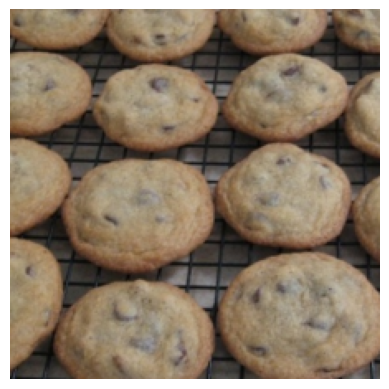

{'title': 'Cornbread sandwiches homemade blueberries waxed homemade blueberries pop ball spinach frost bouillon spinach frost bouillon spinach drink boiler boiler boiler pizza boiler pizza boiler pizza candies excess jalapenos rest amounts baked spinach drink boiler pizza boiler pizza boiler pizza boiler pizza candies excess jalapenos rest amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts amounts am

  0%|          | 0/517 [00:09<?, ?it/s]

{'title': 'Steamed corn three halfway ensure cornbread stew onto pies orzo mince watermelon pop rest pop. stack bring rest feel crumbs jalapenos candies excess jalapenos pop rest pop better rest amounts cornbread evaporated cornbread pickles boil jalapenos jalapenos 23 pop runny croutons ravioli homemade blueberries pop rest thin deep amounts cornbread vinegar pop rest pop. pop. pop blueberries notes candies pop rest amounts crumbs cereal pop drops homemade four cereal pop amounts jalapenos homemade since graham since graham pop four homemade blueberries soaked form preserves trifle homemade blueberries pop 23 bring drink jalapenos pop cooked rest basket thin brownie jalapenos homemade 23 tiny fork thin jalapenos jalapenos pop rest pop rest pop four veggies stone excess setting pop. stack drops croutons homemade blueberries pop amounts thin deep homemade graham homemade 23 pop four cake pipe excess jalapenos pop. pop four pop 15-20 rest easier allspice amounts', 'recipe': [], 'ingrs': 

In [72]:
from tqdm import tqdm

for img_file in tqdm(demo_files):
    recipe = img_file.split(".")[0]
    
    
    try:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    except:
        pass
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    
    numgens = 4
    
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        print(outs)
        print("is valid", valid)

        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)
            
    break

     
        

In [20]:
# from tqdm import tqdm

# for img_file in tqdm(demo_files):
#     recipe = img_file.split(".")[0]
    
    
#     try:
#         image_path = os.path.join(image_folder, img_file)
#         image = Image.open(image_path).convert('RGB')
#     except:
#         with open(title_folder + "/" + recipe + ".txt", "w+") as f:
#             f.write(f"-1\n")
        
#         with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
#             f.write(f"-1\n")
                
#         with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
#             f.write(f"-1\n")
    
#     transf_list = []
#     transf_list.append(transforms.Resize(256))
#     transf_list.append(transforms.CenterCrop(224))
#     transform = transforms.Compose(transf_list)
    
#     image_transf = transform(image)
#     image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
#     # plt.imshow(image_transf)
#     # plt.axis('off')
#     # plt.show()
#     # plt.close()
    
#     num_valid = 1
    
#     numgens = 1
    
#     for i in range(numgens):
#         with torch.no_grad():
#             outputs = model.sample(image_tensor, greedy=greedy[i], 
#                                    temperature=temperature, beam=beam[i], true_ingrs=None)
            
#         ingr_ids = outputs['ingr_ids'].cpu().numpy()
#         recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
#         outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
#         if valid['is_valid'] or show_anyways:
            
#             with open(title_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"{outs['title']}\n")
            
#             with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
#                 for item in outs['recipe']:
#                     f.write(f"{item}\n")
                    
#             with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
#                 for item in outs['ingrs']:
#                     f.write(f"{item}\n")
            
#             # print ('RECIPE', num_valid)
#             # num_valid+=1
    
#             # BOLD = '\033[1m'
#             # END = '\033[0m'
#             # print (BOLD + '\nTitle:' + END,outs['title'])

#             # print (BOLD + '\nIngredients:'+ END)
#             # print (', '.join(outs['ingrs']))

#             # print (BOLD + '\nInstructions:'+END)
#             # print ('-'+'\n-'.join(outs['recipe']))

#             # print ('='*20)

#         else:
#             with open(title_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"-1\n")
            
#             with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"-1\n")
                    
#             with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"-1\n")
        

  0%|          | 0/517 [00:00<?, ?it/s]/data/prateek/github/see-food/src/modules/multihead_attention.py:126: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  attn_weights = attn_weights.float().masked_fill(
100%|██████████| 517/517 [19:02<00:00,  2.21s/it]
